In [1]:
# just in case if needed
# !pip install catboost
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn

## Prerequisities

In [4]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [5]:
toi = pd.read_csv('TOI_Data.csv', comment='#')

## Feature Selection

In [6]:
features = [
    "pl_orbper",      # Orbital period [days]
    "pl_trandurh",    # Transit duration [hours]
    "pl_trandep",     # Transit depth [ppm]

    "pl_eqt",         # Equilibrium temperature [K]
    "st_tmag",        # TESS magnitude
    "st_dist",        # Distance [pc]
    "st_teff",        # Stellar effective temperature [K]
    "st_rad",         # Stellar radius [Solar radii]
    "st_logg",        # Stellar surface gravity [log10(cm/s²)]
    "tfopwg_disp"     # Label: CONFIRMED / CANDIDATE / FALSE POSITIVE
]

drop_list = [
    "toi", "tid",
    "rastr", "ra", "decstr", "dec",
    "st_pmra", "st_pmraerr1", "st_pmraerr2", "st_pmralim",
    "st_pmdec", "st_pmdecerr1", "st_pmdecerr2", "st_pmdeclim",
    "pl_tranmid", "pl_tranmiderr1", "pl_tranmiderr2", "pl_tranmidlim",
    "pl_orbpererr1", "pl_orbpererr2", "pl_orbperlim",
    "pl_trandurherr1", "pl_trandurherr2", "pl_trandurhlim",
    "pl_trandeperr1", "pl_trandeperr2", "pl_trandeplim",
    "pl_radelim",
    "st_tmagerr1", "st_tmagerr2", "st_tmaglim",
    "st_disterr1", "st_disterr2", "st_distlim",
    "st_tefferr1", "st_tefferr2", "st_tefflim",
    "st_logglim",
    "st_radlim",
    "toi_created", "rowupdate",
    "pl_rade", "pl_insol",

    # Missing Data
    "pl_radeerr1", "pl_radeerr2",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim",
    "st_loggerr1", "st_loggerr2",
    "st_raderr1", "st_raderr2"

    # Leakage Data
    "pl_rade", "pl_insol"
]


In [26]:
toi = toi[features]

Label Mapping

In [8]:
label_map = {
    "CP": 1,   # Confirmed Planet
    "KP": 1,   # Known Planet
    "PC": 1,   # Planetary Candidate
    "APC": 1,  # Ambiguous Planetary Candidate
    "FP": 0,  # False Positive
    "FA": 0   # False Alarm
}

toi["tfopwg_disp"] = toi["tfopwg_disp"].map(label_map)

## Filling empty cells

In [9]:
#print(toi.isna().sum())
print(toi.isna().sum() / len(toi) * 100)

pl_orbper       1.389791
pl_trandurh     0.000000
pl_trandep      0.000000
pl_eqt          4.039486
st_tmag         0.000000
st_dist         2.792570
st_teff         2.091181
st_rad          6.585271
st_logg        11.118327
tfopwg_disp     0.000000
dtype: float64


In [10]:
len(toi)

7699

In [11]:
toi.dropna(inplace=True)

In [12]:
len(toi)

6589

In [ ]:
#for col in features:
#    toi[col].fillna(toi[col].median(), inplace=True)

### Diagnoise

In [ ]:
#print(toi.isna().sum()[toi.isna().sum() > 0])
#for col in features:
#    print(toi[col].dtype)

## Defining data sets

In [13]:
X = toi.drop("tfopwg_disp", axis=1)
y = toi["tfopwg_disp"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [15]:
classes = np.unique(y_train)

Calculating Class Weights

In [16]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [17]:
class_weights = dict(zip(classes, weights))

### Cross-validation

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

## Cat Boost Initiation

### Parameters


In [19]:
max_ite = 3000
dep = 8
l_rate = 0.08

In [20]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=7,
    border_count=1024,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [21]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6769748	test: 0.6759749	best: 0.6759749 (0)	total: 191ms	remaining: 9m 31s
50:	learn: 0.4780739	test: 0.4695104	best: 0.4695104 (50)	total: 1.46s	remaining: 1m 24s
100:	learn: 0.4210819	test: 0.4241046	best: 0.4241046 (100)	total: 2.7s	remaining: 1m 17s
150:	learn: 0.3822588	test: 0.3952731	best: 0.3952731 (150)	total: 3.94s	remaining: 1m 14s
200:	learn: 0.3462548	test: 0.3717870	best: 0.3717870 (200)	total: 5.17s	remaining: 1m 12s
250:	learn: 0.3180617	test: 0.3526822	best: 0.3526822 (250)	total: 6.4s	remaining: 1m 10s
300:	learn: 0.2920882	test: 0.3366277	best: 0.3366277 (300)	total: 7.64s	remaining: 1m 8s
350:	learn: 0.2713551	test: 0.3240570	best: 0.3240474 (349)	total: 8.88s	remaining: 1m 7s
400:	learn: 0.2533399	test: 0.3131315	best: 0.3131315 (400)	total: 10.1s	remaining: 1m 5s
450:	learn: 0.2382770	test: 0.3037170	best: 0.3037169 (449)	total: 11.3s	remaining: 1m 4s
500:	learn: 0.2236670	test: 0.2950820	best: 0.2950820 (500)	total: 12.6s	remaining: 1m 2s
550:	learn: 

### Plotting Loss

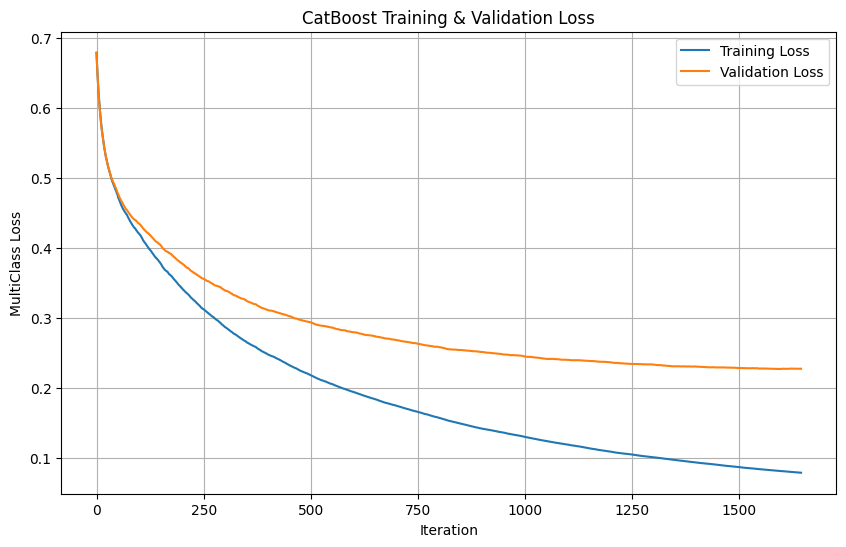

In [ ]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [22]:
y_pred = model.predict(X_test)

### Confusion Matrix

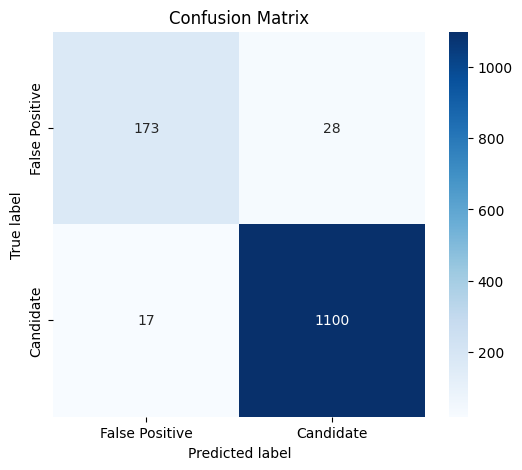

In [23]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["False Positive", "Candidate"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [29]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision Score: {:.2f}%".format(precision * 100))
print("Recall Score: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 96.59%
Precision Score: 96.53%
Recall Score: 96.59%
F1 Score: 96.55%


In [25]:
model.save_model("TESS_Model_Updated.onnx", format="onnx")